In [1]:
%load_ext cython
import Cython
print(Cython.__version__)
# Explore alphashape performance
"""
Focus on that inner loop.



Different approaches:

1. Use Cython
2. Vectorize and try to use nditer and do something there? 
3. Try out https://github.com/sadaszewski/concaveman-cpp
4. Try out https://pysal.org/libpysal/generated/libpysal.cg.alpha_shape.html#libpysal.cg.alpha_shape
"""

0.29.28


'\nFocus on that inner loop.\n\n\n\nDifferent approaches:\n\n1. Use Cython\n2. Vectorize and try to use nditer and do something there? \n3. Try out https://github.com/sadaszewski/concaveman-cpp\n4. Try out https://pysal.org/libpysal/generated/libpysal.cg.alpha_shape.html#libpysal.cg.alpha_shape\n'

In [2]:
import csv
with open("best_results.csv") as fp:
    reader = csv.reader(fp)
    best_results = []
    for i, row in enumerate(reader):
        if i == 0:
            continue
        best_results.append(map(float, row))
        
reachable = [(lng, lat) for lat, lng, travel_time in best_results if travel_time <= 180.0 * 60.0]

In [3]:
# The original algorithm
from collections import defaultdict

import numpy as np
from scipy.spatial import Delaunay
from shapely.geometry import mapping, MultiLineString, MultiPoint, Point, Polygon
from shapely.ops import polygonize, unary_union


ALPHA = 300


def alphashape(points, alpha=None):
    # Adapted from https://git.io/JvXFR for our use case here
    """
    Compute the alpha shape (concave hull) of a set of points.  If the number
    of points in the input is three or less, the convex hull is returned to the
    user.  For two points, the convex hull collapses to a `LineString`; for one
    point, a `Point`.
    Args:
        points (list or ``shapely.geometry.MultiPoint`` or
            ``geopandas.GeoDataFrame``): an iterable container of points
        alpha (float): alpha value
    Returns:
        ``shapely.geometry.Polygon`` or ``shapely.geometry.LineString`` or
        ``shapely.geometry.Point`` or ``geopandas.GeoDataFrame``: the resulting
            geometry
    """
    # If given a triangle for input, or an alpha value of zero or less,
    # return the convex hull.
    if len(points) < 4 or alpha is None or alpha <= 0:
        points = MultiPoint(list(points))
        return points.convex_hull

    coords = np.array(points)
    tri = Delaunay(coords)
    inv_alpha = 1.0 / alpha

    # indices of points making up triangles in the triangulation (pylint disable is for known pylint
    # issue with Delaunay class)
    simplices = tri.simplices  # pylint: disable=no-member

    # Coordinates of each vertex of the triangles
    tri_coords = coords[simplices]

    # Lengths of sides of triangle
    a = np.sqrt(
        np.sum(np.square(tri_coords[:, 0, :] - tri_coords[:, 1, :]), 1))
    b = np.sqrt(
        np.sum(np.square(tri_coords[:, 1, :] - tri_coords[:, 2, :]), 1))
    c = np.sqrt(
        np.sum(np.square(tri_coords[:, 2, :] - tri_coords[:, 0, :]), 1))
    # Semiperimeter of triangle
    s = (a + b + c) * 0.5
    # Area of triangle by Heron's formula
    area = s * (s - a) * (s - b) * (s - c)
    circumradius = a * b * c / (4.0 * np.sqrt(area))
    # Filter based on the circumradius value compared with the alpha value:
    # 1. circumradius is less than inv_alpha -> triangle is included in shape
    # 2. circumradius is finite and >= inv_alpha -> triangle should not be included in shape
    # 3. circumradius is NaN or infinite -> ignore (Due to how we handle holes below, it's
    #    simpler to just skip these triangles altogether.)
    included_triangles = circumradius < inv_alpha
    hole_triangles = np.all(
        [np.isfinite(circumradius), circumradius >= inv_alpha], 0)

    # If none of the triangles are included in the shape, fallback to convex hull (rather than
    # returning empty geometry)
    if not np.any(included_triangles):
        points = MultiPoint(list(points))
        return points.convex_hull

    # Count how many faces (triangles) included in alphashape each edge has (0, 1, or 2)
    internal_faces_count = defaultdict(int)
    for ia, ib, ic in simplices[included_triangles]:
        for i, j in [(ia, ib), (ib, ic), (ic, ia)]:
            ordered_indices = (i, j) if i < j else (j, i)
            internal_faces_count[ordered_indices] += 1

    # Collect faces (triangles) that are not in alphashape
    holes = [Polygon([pa, pb, pc])
             for pa, pb, pc in tri_coords[hole_triangles]]

    # Compute the alphashape by finding all the edges on the boundary of the shape, which is all
    # edges which make up exactly one triangle included in the alphashape. However, since we don't
    # know whether each of these edges should be part of the exterior ring(s) of the shape or
    # interior rings (holes), we treat them all as exterior (by polygonizing + unioning them). We
    # then difference out the holes (those triangles excluded from the alphashape), to arrive at the
    # correct alphashape.
    #
    # NOTE: Conceptually, this is equivalent to computing the union of all triangles included in the
    # alphashape (and what the library this is copied from does). However, since there are often far
    # more triangles included in the shape than excluded, it is significantly faster doing it as
    # outlined above instead. This is also equivalent to computing the convex hull and differencing
    # out the holes from that, but the above is slightly faster
    #
    # TODO: We shouldn't need to do any unioning at all here - if we properly track the half edges
    # (oriented edges associated with a single face), we can track half edges on the boundary and
    # determine directly if the rings they form are CW or CCW winding to determine if they are a
    # hole or not. But doing this is fast enough for now, so not making this optimization yet.
    boundary_edges = []
    for (i, j), count in internal_faces_count.items():
        assert count in (1, 2), f"({i},{j}): {count}"
        if count == 1:
            boundary_edges.append(coords[[i, j]])

    m = MultiLineString(boundary_edges)
    exterior_polygons = unary_union(list(polygonize(m)))

    valid_holes = []
    for hole in holes:
        if not hole.is_valid:
            print(f"invalid hole: {mapping(hole)}")
            hole = hole.buffer(0)
        valid_holes.append(hole)

    try:
        hole_polygons = unary_union(valid_holes)
    except ValueError as e:
        holes_json = [mapping(hole) for hole in valid_holes]
        print(
            f"Error constructing holes multipolygon:\nholes: {holes_json}\nexception: {e}"
        )
        raise e

    return exterior_polygons.difference(hole_polygons)


In [4]:
%timeit alphashape(reachable, ALPHA)

1.25 s ± 9.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


CPU times: user 1.25 s, sys: 3.81 ms, total: 1.26 s
Wall time: 1.25 s


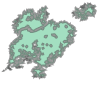

In [5]:
%time alphashape(reachable, ALPHA)

In [6]:
len(reachable)

125332

In [7]:
import libpysal
import numpy as np

reachable_np = np.array(reachable)

%time libpysal.cg.alpha_shape(reachable_np, ALPHA)

CPU times: user 2.04 s, sys: 3.64 ms, total: 2.04 s
Wall time: 2.04 s


0      POLYGON ((-85.86783 38.28495, -85.86443 38.281...
7      POLYGON ((-85.87393 38.32387, -85.87488 38.323...
9      POLYGON ((-85.85707 38.33710, -85.85653 38.340...
12     POLYGON ((-85.85121 38.33579, -85.85707 38.337...
14     POLYGON ((-85.90495 38.01696, -85.90612 38.018...
15     POLYGON ((-85.85766 38.02205, -85.85668 38.021...
16     POLYGON ((-85.85668 38.02145, -85.85058 38.022...
17     POLYGON ((-85.79725 38.08054, -85.79813 38.078...
18     POLYGON ((-85.78784 38.07784, -85.78922 38.080...
20     POLYGON ((-85.90848 38.03354, -85.91152 38.031...
28     POLYGON ((-85.78810 38.09476, -85.79129 38.093...
32     POLYGON ((-85.83449 38.02756, -85.83120 38.030...
38     POLYGON ((-85.91844 38.02105, -85.92116 38.018...
39     POLYGON ((-85.92463 38.01497, -85.92696 38.012...
40     POLYGON ((-85.93601 38.00704, -85.93643 38.005...
42     POLYGON ((-85.90387 38.00790, -85.90019 38.009...
51     POLYGON ((-85.78660 38.07025, -85.79013 38.065...
55     POLYGON ((-85.80910 38.0

In [8]:
%timeit libpysal.cg.alpha_shape(reachable_np, ALPHA)

1.02 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<AxesSubplot:>

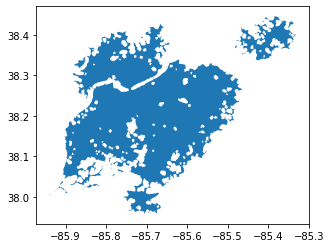

In [9]:
# So, that is pretty decent, but means we can't use more recent versions of numpy... have to use 1.21
libpysal.cg.alpha_shape(reachable_np, ALPHA).plot()

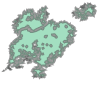

In [10]:
alphashape(reachable, ALPHA)

In [26]:
%%cython
# cython: infer_types=True
cimport cython
from collections import defaultdict

import numpy as np
from scipy.spatial import Delaunay
from shapely.geometry import mapping, MultiLineString, MultiPoint, Point, Polygon
from shapely.ops import polygonize, unary_union


ALPHA = 300

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def alphashape_cython(points, alpha=None):
    # Adapted from https://git.io/JvXFR for our use case here
    """
    Compute the alpha shape (concave hull) of a set of points.  If the number
    of points in the input is three or less, the convex hull is returned to the
    user.  For two points, the convex hull collapses to a `LineString`; for one
    point, a `Point`.
    Args:
        points (list or ``shapely.geometry.MultiPoint`` or
            ``geopandas.GeoDataFrame``): an iterable container of points
        alpha (float): alpha value
    Returns:
        ``shapely.geometry.Polygon`` or ``shapely.geometry.LineString`` or
        ``shapely.geometry.Point`` or ``geopandas.GeoDataFrame``: the resulting
            geometry
    """
    # If given a triangle for input, or an alpha value of zero or less,
    # return the convex hull.
    if len(points) < 4 or alpha is None or alpha <= 0:
        points = MultiPoint(list(points))
        return points.convex_hull

    coords = np.array(points)
    tri = Delaunay(coords)
    inv_alpha = 1.0 / alpha

    # indices of points making up triangles in the triangulation (pylint disable is for known pylint
    # issue with Delaunay class)
    simplices = tri.simplices  # pylint: disable=no-member

    # Coordinates of each vertex of the triangles
    tri_coords = coords[simplices]

    # Lengths of sides of triangle
    a = np.sqrt(
        np.sum(np.square(tri_coords[:, 0, :] - tri_coords[:, 1, :]), 1))
    b = np.sqrt(
        np.sum(np.square(tri_coords[:, 1, :] - tri_coords[:, 2, :]), 1))
    c = np.sqrt(
        np.sum(np.square(tri_coords[:, 2, :] - tri_coords[:, 0, :]), 1))
    # Semiperimeter of triangle
    s = (a + b + c) * 0.5
    # Area of triangle by Heron's formula
    area = s * (s - a) * (s - b) * (s - c)
    circumradius = a * b * c / (4.0 * np.sqrt(area))
    # Filter based on the circumradius value compared with the alpha value:
    # 1. circumradius is less than inv_alpha -> triangle is included in shape
    # 2. circumradius is finite and >= inv_alpha -> triangle should not be included in shape
    # 3. circumradius is NaN or infinite -> ignore (Due to how we handle holes below, it's
    #    simpler to just skip these triangles altogether.)
    included_triangles = circumradius < inv_alpha
    hole_triangles = np.all(
        [np.isfinite(circumradius), circumradius >= inv_alpha], 0)

    # If none of the triangles are included in the shape, fallback to convex hull (rather than
    # returning empty geometry)
    if not np.any(included_triangles):
        points = MultiPoint(list(points))
        return points.convex_hull

    # Count how many faces (triangles) included in alphashape each edge has (0, 1, or 2)
    internal_faces_count = defaultdict(int)
    tri_edges = simplices[included_triangles]
    for ia, ib, ic in tri_edges:
        for i, j in [(ia, ib), (ib, ic), (ic, ia)]:
            ordered_indices = (i, j) if i < j else (j, i)
            internal_faces_count[ordered_indices] += 1

    # Collect faces (triangles) that are not in alphashape
    holes = [Polygon([pa, pb, pc])
             for pa, pb, pc in tri_coords[hole_triangles]]

    # Compute the alphashape by finding all the edges on the boundary of the shape, which is all
    # edges which make up exactly one triangle included in the alphashape. However, since we don't
    # know whether each of these edges should be part of the exterior ring(s) of the shape or
    # interior rings (holes), we treat them all as exterior (by polygonizing + unioning them). We
    # then difference out the holes (those triangles excluded from the alphashape), to arrive at the
    # correct alphashape.
    #
    # NOTE: Conceptually, this is equivalent to computing the union of all triangles included in the
    # alphashape (and what the library this is copied from does). However, since there are often far
    # more triangles included in the shape than excluded, it is significantly faster doing it as
    # outlined above instead. This is also equivalent to computing the convex hull and differencing
    # out the holes from that, but the above is slightly faster
    #
    # TODO: We shouldn't need to do any unioning at all here - if we properly track the half edges
    # (oriented edges associated with a single face), we can track half edges on the boundary and
    # determine directly if the rings they form are CW or CCW winding to determine if they are a
    # hole or not. But doing this is fast enough for now, so not making this optimization yet.
    boundary_edges = []
    for (i, j), count in internal_faces_count.items():
        assert count in (1, 2), f"({i},{j}): {count}"
        if count == 1:
            boundary_edges.append(coords[[i, j]])

    m = MultiLineString(boundary_edges)
    exterior_polygons = unary_union(list(polygonize(m)))

    valid_holes = []
    for hole in holes:
        if not hole.is_valid:
            print(f"invalid hole: {mapping(hole)}")
            hole = hole.buffer(0)
        valid_holes.append(hole)

    try:
        hole_polygons = unary_union(valid_holes)
    except ValueError as e:
        holes_json = [mapping(hole) for hole in valid_holes]
        print(
            f"Error constructing holes multipolygon:\nholes: {holes_json}\nexception: {e}"
        )
        raise e

    return exterior_polygons.difference(hole_polygons)

In [27]:
%timeit alphashape_cython(reachable, ALPHA)

1.2 s ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%cython
# cython: infer_types=True
cimport cython
from collections import defaultdict

import numpy as np
from scipy.spatial import Delaunay
from shapely.geometry import mapping, MultiLineString, MultiPoint, Point, Polygon
from shapely.ops import polygonize, unary_union


ALPHA = 300

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def alphashape_cython_memoryview(points, alpha=None):
    # Adapted from https://git.io/JvXFR for our use case here
    """
    Compute the alpha shape (concave hull) of a set of points.  If the number
    of points in the input is three or less, the convex hull is returned to the
    user.  For two points, the convex hull collapses to a `LineString`; for one
    point, a `Point`.
    Args:
        points (list or ``shapely.geometry.MultiPoint`` or
            ``geopandas.GeoDataFrame``): an iterable container of points
        alpha (float): alpha value
    Returns:
        ``shapely.geometry.Polygon`` or ``shapely.geometry.LineString`` or
        ``shapely.geometry.Point`` or ``geopandas.GeoDataFrame``: the resulting
            geometry
    """
    # cdef float[:, :] coords 
    cdef int[:, :] tri_edges
    # cdef float[:] a
    #cdef float[:] b
    # cdef float[:] c
    # If given a triangle for input, or an alpha value of zero or less,
    # return the convex hull.
    if len(points) < 4 or alpha is None or alpha <= 0:
        points = MultiPoint(list(points))
        return points.convex_hull

    coords = np.array(points)
    tri = Delaunay(coords)
    inv_alpha = 1.0 / alpha

    # indices of points making up triangles in the triangulation (pylint disable is for known pylint
    # issue with Delaunay class)
    simplices = tri.simplices  # pylint: disable=no-member

    # Coordinates of each vertex of the triangles
    tri_coords = coords[simplices]

    # Lengths of sides of triangle
    a = np.sqrt(
        np.sum(np.square(tri_coords[:, 0, :] - tri_coords[:, 1, :]), 1))
    b = np.sqrt(
        np.sum(np.square(tri_coords[:, 1, :] - tri_coords[:, 2, :]), 1))
    c = np.sqrt(
        np.sum(np.square(tri_coords[:, 2, :] - tri_coords[:, 0, :]), 1))
    # Semiperimeter of triangle
    s = (a + b + c) * 0.5
    # Area of triangle by Heron's formula
    area = s * (s - a) * (s - b) * (s - c)
    circumradius = a * b * c / (4.0 * np.sqrt(area))
    # Filter based on the circumradius value compared with the alpha value:
    # 1. circumradius is less than inv_alpha -> triangle is included in shape
    # 2. circumradius is finite and >= inv_alpha -> triangle should not be included in shape
    # 3. circumradius is NaN or infinite -> ignore (Due to how we handle holes below, it's
    #    simpler to just skip these triangles altogether.)
    included_triangles = circumradius < inv_alpha
    hole_triangles = np.all(
        [np.isfinite(circumradius), circumradius >= inv_alpha], 0)

    # If none of the triangles are included in the shape, fallback to convex hull (rather than
    # returning empty geometry)
    if not np.any(included_triangles):
        points = MultiPoint(list(points))
        return points.convex_hull

    # Count how many faces (triangles) included in alphashape each edge has (0, 1, or 2)
    internal_faces_count = defaultdict(int)
    tri_edges = simplices[included_triangles]
    for ia, ib, ic in tri_edges:
        for i, j in [(ia, ib), (ib, ic), (ic, ia)]:
            ordered_indices = (i, j) if i < j else (j, i)
            internal_faces_count[ordered_indices] += 1

    # Collect faces (triangles) that are not in alphashape
    holes = [Polygon([pa, pb, pc])
             for pa, pb, pc in tri_coords[hole_triangles]]

    # Compute the alphashape by finding all the edges on the boundary of the shape, which is all
    # edges which make up exactly one triangle included in the alphashape. However, since we don't
    # know whether each of these edges should be part of the exterior ring(s) of the shape or
    # interior rings (holes), we treat them all as exterior (by polygonizing + unioning them). We
    # then difference out the holes (those triangles excluded from the alphashape), to arrive at the
    # correct alphashape.
    #
    # NOTE: Conceptually, this is equivalent to computing the union of all triangles included in the
    # alphashape (and what the library this is copied from does). However, since there are often far
    # more triangles included in the shape than excluded, it is significantly faster doing it as
    # outlined above instead. This is also equivalent to computing the convex hull and differencing
    # out the holes from that, but the above is slightly faster
    #
    # TODO: We shouldn't need to do any unioning at all here - if we properly track the half edges
    # (oriented edges associated with a single face), we can track half edges on the boundary and
    # determine directly if the rings they form are CW or CCW winding to determine if they are a
    # hole or not. But doing this is fast enough for now, so not making this optimization yet.
    boundary_edges = []
    for (i, j), count in internal_faces_count.items():
        assert count in (1, 2), f"({i},{j}): {count}"
        if count == 1:
            boundary_edges.append(coords[[i, j]])

    m = MultiLineString(boundary_edges)
    exterior_polygons = unary_union(list(polygonize(m)))

    valid_holes = []
    for hole in holes:
        if not hole.is_valid:
            print(f"invalid hole: {mapping(hole)}")
            hole = hole.buffer(0)
        valid_holes.append(hole)

    try:
        hole_polygons = unary_union(valid_holes)
    except ValueError as e:
        holes_json = [mapping(hole) for hole in valid_holes]
        print(
            f"Error constructing holes multipolygon:\nholes: {holes_json}\nexception: {e}"
        )
        raise e

    return exterior_polygons.difference(hole_polygons)

In [29]:
%timeit alphashape_cython_memoryview(reachable, ALPHA)

1.39 s ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
import math
def alphashape_original(points, alpha=None):
    # Adapted from https://git.io/JvXFR for our use case here
    """
    Compute the alpha shape (concave hull) of a set of points.  If the number
    of points in the input is three or less, the convex hull is returned to the
    user.  For two points, the convex hull collapses to a `LineString`; for one
    point, a `Point`.
    Args:
        points (list or ``shapely.geometry.MultiPoint`` or
            ``geopandas.GeoDataFrame``): an iterable container of points
        alpha (float): alpha value
    Returns:
        ``shapely.geometry.Polygon`` or ``shapely.geometry.LineString`` or
        ``shapely.geometry.Point`` or ``geopandas.GeoDataFrame``: the resulting
            geometry
    """
    # If given a triangle for input, or an alpha value of zero or less,
    # return the convex hull.
    if len(points) < 4 or alpha is None or alpha <= 0:
        points = MultiPoint(list(points))
        return points.convex_hull

    coords = np.array(points)
    tri = Delaunay(coords)
    inv_alpha = 1.0 / alpha

    # Track how many faces (triangles) included in alphashape each edge has (0, 1, or 2)
    internal_faces_count = defaultdict(int)
    # Track faces (triangles) that are not in alphashape
    holes = []

    # Loop over triangles (pylint disable is for known pylint issue with Delaunay class)
    for ia, ib, ic in tri.simplices:  # pylint: disable=no-member
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = math.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = math.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)

        # Semiperimeter of triangle
        s = (a + b + c) * 0.5

        # Area of triangle by Heron's formula
        area = s * (s - a) * (s - b) * (s - c)
        if area <= 0:
            # An area of 0 causes unbounded math errors for the circumradius check, so needs special
            # handling. Further, zero area triangles have no meaningful impact on the result. Due to
            # how we handle holes below, it's simpler to just skip these triangles altogether.
            continue
        # Circumradius Filter
        is_included = a * b * c / (4.0 * math.sqrt(area)) < inv_alpha
        if is_included:
            for i, j in [(ia, ib), (ib, ic), (ic, ia)]:
                ordered_indices = (i, j) if i < j else (j, i)
                internal_faces_count[ordered_indices] += 1
        else:
            holes.append(Polygon([pa, pb, pc]))

    # If none of the triangles are included in the shape, fallback to convex hull (rather than
    # returning empty geometry)
    if len(internal_faces_count) == 0:
        points = MultiPoint(list(points))
        return points.convex_hull

    # Compute the alphashape by finding all the edges on the boundary of the shape, which is all
    # edges which make up exactly one triangle included in the alphashape. However, since we don't
    # know whether each of these edges should be part of the exterior ring(s) of the shape or
    # interior rings (holes), we treat them all as exterior (by polygonizing + unioning them). We
    # then difference out the holes (those triangles excluded from the alphashape), to arrive at the
    # correct alphashape.
    #
    # NOTE: Conceptually, this is equivalent to computing the union of all triangles included in the
    # alphashape (and what the library this is copied from does). However, since there are often far
    # more triangles included in the shape than excluded, it is significantly faster doing it as
    # outlined above instead. This is also equivalent to computing the convex hull and differencing
    # out the holes from that, but the above is slightly faster
    #
    # TODO: We shouldn't need to do any unioning at all here - if we properly track the half edges
    # (oriented edges associated with a single face), we can track half edges on the boundary and
    # determine directly if the rings they form are CW or CCW winding to determine if they are a
    # hole or not. But doing this is fast enough for now, so not making this optimization yet.
    boundary_edges = []
    for (i, j), count in internal_faces_count.items():
        assert count in (1, 2), f"({i},{j}): {count}"
        if count == 1:
            boundary_edges.append(coords[[i, j]])

    m = MultiLineString(boundary_edges)
    exterior_polygons = unary_union(list(polygonize(m)))

    valid_holes = []
    for hole in holes:
        if not hole.is_valid:
            logger.warning(f"invalid hole: {mapping(hole)}")
            hole = hole.buffer(0)
        valid_holes.append(hole)

    try:
        hole_polygons = unary_union(valid_holes)
    except ValueError as e:
        holes_json = [mapping(hole) for hole in valid_holes]
        logger.warning(
            f"Error constructing holes multipolygon:\nholes: {holes_json}\nexception: {e}"
        )
        raise e

    return exterior_polygons.difference(hole_polygons)

In [33]:
%timeit alphashape_original(reachable, ALPHA)

1.52 s ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%%cython
# cython: infer_types=True
cimport cython

import math
from collections import defaultdict
from functools import partial

import numpy as np
from pyproj import Proj
from scipy.spatial import Delaunay
from shapely.geometry import mapping, MultiLineString, MultiPoint, Point, Polygon
from shapely.ops import polygonize, transform, unary_union

@cython.boundscheck(False)
@cython.wraparound(False)
def alphashape_original_with_cython(points, alpha=None):
    # Adapted from https://git.io/JvXFR for our use case here
    """
    Compute the alpha shape (concave hull) of a set of points.  If the number
    of points in the input is three or less, the convex hull is returned to the
    user.  For two points, the convex hull collapses to a `LineString`; for one
    point, a `Point`.
    Args:
        points (list or ``shapely.geometry.MultiPoint`` or
            ``geopandas.GeoDataFrame``): an iterable container of points
        alpha (float): alpha value
    Returns:
        ``shapely.geometry.Polygon`` or ``shapely.geometry.LineString`` or
        ``shapely.geometry.Point`` or ``geopandas.GeoDataFrame``: the resulting
            geometry
    """
    # If given a triangle for input, or an alpha value of zero or less,
    # return the convex hull.
    cdef double[:, :] coords
    cdef int[:, :] simplices
                   
    if len(points) < 4 or alpha is None or alpha <= 0:
        points = MultiPoint(list(points))
        return points.convex_hull

    coords = np.array(points)
    tri = Delaunay(coords)
    inv_alpha = 1.0 / alpha

    # Track how many faces (triangles) included in alphashape each edge has (0, 1, or 2)
    internal_faces_count = defaultdict(int)
    # Track faces (triangles) that are not in alphashape
    holes = []
    simplices = tri.simplices
    # Loop over triangles (pylint disable is for known pylint issue with Delaunay class)
    for ia, ib, ic in simplices:  # pylint: disable=no-member
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = math.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = math.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)

        # Semiperimeter of triangle
        s = (a + b + c) * 0.5

        # Area of triangle by Heron's formula
        area = s * (s - a) * (s - b) * (s - c)
        if area <= 0:
            # An area of 0 causes unbounded math errors for the circumradius check, so needs special
            # handling. Further, zero area triangles have no meaningful impact on the result. Due to
            # how we handle holes below, it's simpler to just skip these triangles altogether.
            continue
        # Circumradius Filter
        is_included = a * b * c / (4.0 * math.sqrt(area)) < inv_alpha
        if is_included:
            for i, j in [(ia, ib), (ib, ic), (ic, ia)]:
                ordered_indices = (i, j) if i < j else (j, i)
                internal_faces_count[ordered_indices] += 1
        else:
            holes.append(Polygon([pa, pb, pc]))

    # If none of the triangles are included in the shape, fallback to convex hull (rather than
    # returning empty geometry)
    if len(internal_faces_count) == 0:
        points = MultiPoint(list(points))
        return points.convex_hull

    # Compute the alphashape by finding all the edges on the boundary of the shape, which is all
    # edges which make up exactly one triangle included in the alphashape. However, since we don't
    # know whether each of these edges should be part of the exterior ring(s) of the shape or
    # interior rings (holes), we treat them all as exterior (by polygonizing + unioning them). We
    # then difference out the holes (those triangles excluded from the alphashape), to arrive at the
    # correct alphashape.
    #
    # NOTE: Conceptually, this is equivalent to computing the union of all triangles included in the
    # alphashape (and what the library this is copied from does). However, since there are often far
    # more triangles included in the shape than excluded, it is significantly faster doing it as
    # outlined above instead. This is also equivalent to computing the convex hull and differencing
    # out the holes from that, but the above is slightly faster
    #
    # TODO: We shouldn't need to do any unioning at all here - if we properly track the half edges
    # (oriented edges associated with a single face), we can track half edges on the boundary and
    # determine directly if the rings they form are CW or CCW winding to determine if they are a
    # hole or not. But doing this is fast enough for now, so not making this optimization yet.
    boundary_edges = []
    for (i, j), count in internal_faces_count.items():
        assert count in (1, 2), f"({i},{j}): {count}"
        if count == 1:
            boundary_edges.append([coords[i], coords[j]])

    m = MultiLineString(boundary_edges)
    exterior_polygons = unary_union(list(polygonize(m)))

    valid_holes = []
    for hole in holes:
        if not hole.is_valid:
            print(f"invalid hole: {mapping(hole)}")
            hole = hole.buffer(0)
        valid_holes.append(hole)

    try:
        hole_polygons = unary_union(valid_holes)
    except ValueError as e:
        holes_json = [mapping(hole) for hole in valid_holes]
        print(
            f"Error constructing holes multipolygon:\nholes: {holes_json}\nexception: {e}"
        )
        raise e

    return exterior_polygons.difference(hole_polygons)

In [43]:
%timeit alphashape_original_with_cython(reachable, ALPHA)

1.99 s ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
